In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from polygon import RESTClient
import time

API_KEY = "qZjobWEw7wU6mutIdeE19pDHXcPzbp4R"

client = RESTClient(API_KEY)

tickers = ["PHM", "TOL"]
start_date = "2023-03-01"
end_date = "2024-03-01"

data_dict = {}

for ticker in tickers:
    try:
        bars = client.get_aggs(ticker=ticker, multiplier=1, timespan="day", from_=start_date, to=end_date)
        df = pd.DataFrame(bars)
        df["date"] = pd.to_datetime(df["timestamp"], unit="ms")  
        df.set_index("date", inplace=True)
        data_dict[ticker] = df["close"]
        print(f"✅ Downloaded data for {ticker}")
        time.sleep(1) 
    except Exception as e:
        print(f"❌ Failed to download {ticker}: {e}")

data = pd.DataFrame(data_dict)

data.head()

stock1, stock2 = "PHM", "TOL"

spread = data[stock1] - data[stock2]

rolling_mean = spread.rolling(window=30).mean()
rolling_std = spread.rolling(window=30).std()

z_score = (spread - rolling_mean) / rolling_std

signals = pd.DataFrame(index=data.index)
signals["Spread"] = spread
signals["Z-Score"] = z_score

signals["Long Entry"] = z_score < -2   # Buy PHM, Sell TOL
signals["Short Entry"] = z_score > 2   # Sell PHM, Buy TOL
signals["Exit"] = (z_score > -0.5) & (z_score < 0.5)  # Close position

signals.head()

✅ Downloaded data for PHM
✅ Downloaded data for TOL


,Spread,Z-Score,Long Entry,Short Entry,Exit
date,,,,,
2023-03-08 05:00:00,-4.78,NaN,False,False,False
2023-03-09 05:00:00,-3.85,NaN,False,False,False
2023-03-10 05:00:00,-3.90,NaN,False,False,False
2023-03-13 04:00:00,-3.19,NaN,False,False,False
2023-03-14 04:00:00,-3.46,NaN,False,False,False


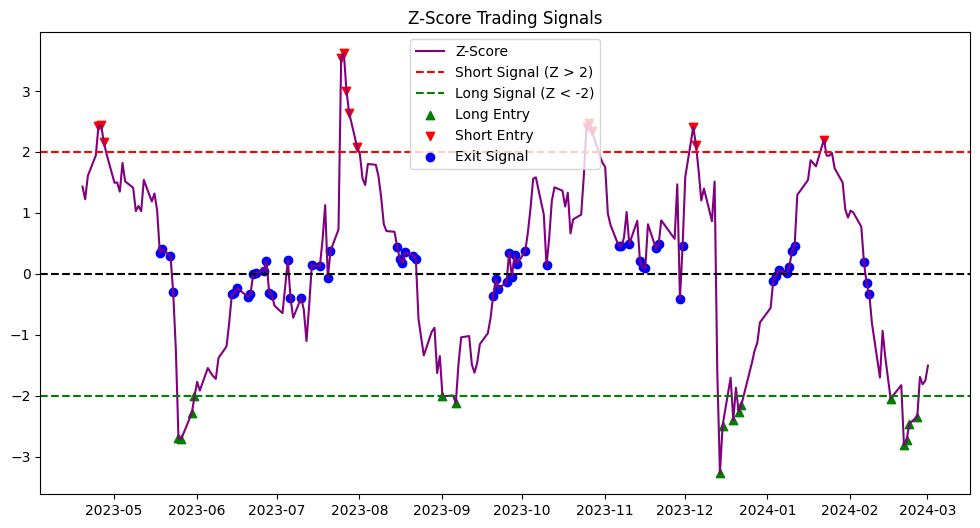

In [2]:
plt.figure(figsize=(12, 6))


plt.plot(z_score, label="Z-Score", color="purple")
plt.axhline(0, color="black", linestyle="--")
plt.axhline(2, color="red", linestyle="--", label="Short Signal (Z > 2)")
plt.axhline(-2, color="green", linestyle="--", label="Long Signal (Z < -2)")

plt.scatter(signals.index[signals["Long Entry"]], z_score[signals["Long Entry"]], color="green", marker="^", label="Long Entry")
plt.scatter(signals.index[signals["Short Entry"]], z_score[signals["Short Entry"]], color="red", marker="v", label="Short Entry")
plt.scatter(signals.index[signals["Exit"]], z_score[signals["Exit"]], color="blue", marker="o", label="Exit Signal")

plt.legend()
plt.title("Z-Score Trading Signals")
plt.show()

In [3]:
signals["Position"] = 0

signals.loc[signals["Long Entry"], "Position"] = 1
signals.loc[signals["Short Entry"], "Position"] = -1

signals.loc[signals["Exit"], "Position"] = 0

signals["Position"] = signals["Position"].replace(0, np.nan).ffill().fillna(0)

signals.head()

,Spread,Z-Score,Long Entry,Short Entry,Exit,Position
date,,,,,,
2023-03-08 05:00:00,-4.78,NaN,False,False,False,0.0
2023-03-09 05:00:00,-3.85,NaN,False,False,False,0.0
2023-03-10 05:00:00,-3.90,NaN,False,False,False,0.0
2023-03-13 04:00:00,-3.19,NaN,False,False,False,0.0
2023-03-14 04:00:00,-3.46,NaN,False,False,False,0.0
